# About
Roughwork code for comparing BTC and ETH returns.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import fattails.metrics as fattails

Datasource:
* BTC: https://finance.yahoo.com/quote/BTC-USD/history/
* ETH: https://finance.yahoo.com/quote/ETH-USD/history/

In [2]:
btc_filepath = '../data/crypto/BTC-USD.csv'
eth_filepath = '../data/crypto/ETH-USD.csv'

# Setup

In [3]:
def prices_to_returns(prices):
    """ Convert price data into percentage return data.

    Each data entry is replaced by it's percentage change 
    vs. the entry before it.
    
    Parameters
    ----------
    sr : pd.Series
        Price data.

    Returns
    -------
    returns : pd.Series
        Percentage return data.
        
    Example
    -------
    >>> # Initialise a price series
    >>> prices = pd.Series([100, 101, 100, 125])
    0    100
    1    101
    2    100
    3    125
    dtype: int64
    >>> # Convert Prices to Returns
    >>> convert_prices_to_returns(prices)
    1    0.010000
    2   -0.009901
    3    0.250000
    dtype: float64
    """
    # Caluculate Returns
    previous_prices = prices.shift(1)
    returns = prices / previous_prices - 1
    
    # Remove First Period
    returns = returns.iloc[1:]  # The first entry has no prior day so return is NaN
        
    return returns

In [4]:
prices = pd.Series([100, 101, 100, 125])

prices_to_returns(prices)

1    0.010000
2   -0.009901
3    0.250000
dtype: float64

##### Load Data

In [5]:
# Load Prices
btc_prices = pd.read_csv(btc_filepath, index_col=0, parse_dates=[0])
btc_prices = btc_prices.Close.rename('prices')
display(btc_prices)

eth_prices = pd.read_csv(eth_filepath, index_col=0, parse_dates=[0])
eth_prices = eth_prices.Close.rename('prices')

display(eth_prices)

Date
2014-09-17      457.334015
2014-09-18      424.440002
2014-09-19      394.795990
2014-09-20      408.903992
2014-09-21      398.821014
                  ...     
2021-04-19    55724.265625
2021-04-20    56473.031250
2021-04-21    53906.089844
2021-04-22    51762.273438
2021-04-23    49192.179688
Name: prices, Length: 2411, dtype: float64

Date
2015-08-07       2.772120
2015-08-08       0.753325
2015-08-09       0.701897
2015-08-10       0.708448
2015-08-11       1.067860
                 ...     
2021-04-19    2166.188721
2021-04-20    2330.210938
2021-04-21    2364.751709
2021-04-22    2403.535156
2021-04-23    2235.869873
Name: prices, Length: 2087, dtype: float64

In [6]:
# Calculate Returns
btc_returns = prices_to_returns(btc_prices)
eth_returns = prices_to_returns(eth_prices)

basket_returns = (btc_returns + eth_returns)/2  # Basket where you rebalance to 50:50 at end of each day.
basket_returns

Date
2014-09-18         NaN
2014-09-19         NaN
2014-09-20         NaN
2014-09-21         NaN
2014-09-22         NaN
                ...   
2021-04-19   -0.020232
2021-04-20    0.044578
2021-04-21   -0.015316
2021-04-22   -0.011684
2021-04-23   -0.059705
Name: prices, Length: 2410, dtype: float64

In [7]:
# Create DataFrame
returns_df = pd.concat([btc_returns, eth_returns], \
                       keys=['btc_returns','eth_returns'], \
                       axis=1, join='inner')

# Add Mean Return Column
returns_df['mean_returns'] = returns_df.mean(axis=1)

returns_df.head()

,btc_returns,eth_returns,mean_returns
Date,,,
2015-08-08,-0.066484,-0.728249,-0.397367
2015-08-09,0.015655,-0.068268,-0.026306
2015-08-10,-0.002313,0.009333,0.003510
2015-08-11,0.022369,0.507323,0.264846
2015-08-12,-0.014831,0.140075,0.062622


### Missing Data Check

In [8]:
# NaN Values in Returns Data
returns_df.loc[returns_df.isna().any(axis=1)]

,btc_returns,eth_returns,mean_returns
Date,,,
2020-04-17,NaN,NaN,NaN
2020-04-18,NaN,NaN,NaN
2020-10-09,NaN,NaN,NaN
2020-10-10,NaN,NaN,NaN
2020-10-12,NaN,NaN,NaN
2020-10-13,NaN,NaN,NaN
2020-10-14,NaN,NaN,NaN


In [9]:
# NaN Values in ETH Prices
eth_prices.iloc[1:][returns_df.isna().any(axis=1)]

Date
2020-04-17           NaN
2020-04-18    186.914001
2020-10-09           NaN
2020-10-10    370.967590
2020-10-12           NaN
2020-10-13           NaN
2020-10-14    379.484039
Name: prices, dtype: float64

In [10]:
# NaN Values in BTC Prices
btc_prices.loc[returns_df.index][returns_df.isna().any(axis=1)]

Date
2020-04-17             NaN
2020-04-18     7257.665039
2020-10-09             NaN
2020-10-10    11296.361328
2020-10-12             NaN
2020-10-13             NaN
2020-10-14    11429.506836
Name: prices, dtype: float64

In [11]:
# Drop Nan Values from Returns
returns_df.dropna(inplace=True)

# Analyse

### Simple Plot

In [12]:
returns_df.max()

btc_returns     0.252472
eth_returns     0.507323
mean_returns    0.264846
dtype: float64

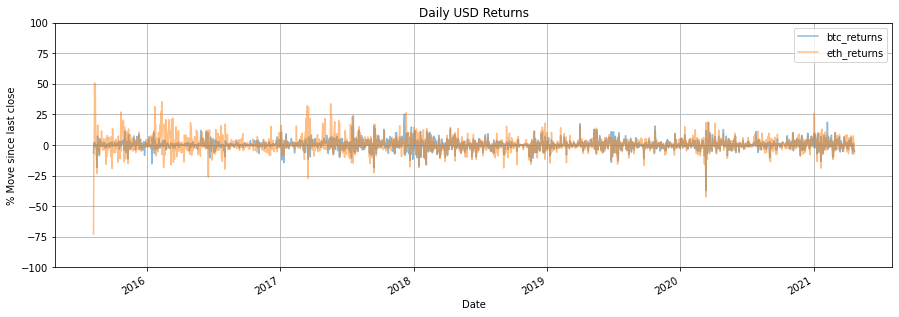

In [13]:
# Plot
(returns_df*100).loc[:,['btc_returns','eth_returns']] \
                .plot(figsize=[15,5], alpha=0.5, grid=True, \
                      ylim=[-100,100],  ylabel='% Move since last close', \
                      title='Daily USD Returns');